In [1]:
import arviz as az
import pymc3 as pm
import pystan
import emcee
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Model

The model on which to perform the simulation will be the estimation of the mean of a Normal variable having observed a 0. We will use:

$$ 
p(\theta) = \mathcal{N}(0, 10)\\
p(y|\theta) = \mathcal{N}(\theta, 2)\\
p(\theta|y) \sim p(y|\theta)p(\theta) \sim \exp\left(-\frac{(y-\theta)^2}{8}\right)\exp\left(-\frac{\theta^2}{200}\right)\\
p(\theta|0) \sim \exp\left(-\frac{\theta^2}{8}\right)\exp\left(-\frac{\theta^2}{200}\right) = \exp\left(-\frac{\theta^2}{200/26}\right)
$$

Therefore, our posterior can be calculated analytically, and it turns out to be $\mathcal{N}(0, \frac{10}{\sqrt{26}})$, whose pdf is:

$$ p(\theta|0) = \frac{1}{\sqrt{2\pi}\frac{100}{26}} \exp\left(-\frac{13\theta^2}{100}\right)$$

In [7]:
sigma2 = 100/26

## Utils

In [8]:
def ess_evolution(samples):
    chains, draws = samples.shape
    idxs = np.unique(np.geomspace(5, draws, 500, dtype=int))
    ess_samples = np.empty(idxs.size)
    for i, idx in enumerate(idxs):
        ess_samples[i] = az.ess(samples[:, :idx], method="mean")
    return idxs, ess_samples

def plot_ess_evolution(samples, idxs, ess_samples, title="", variance=sigma2):
    chains, draws = samples.shape
    plt.loglog((samples.sum(axis=0).cumsum() / (np.arange(draws)*chains)) ** 2, label="var_err");
    plt.loglog(idxs, sigma2/ess_samples, label="var/ess");
    plt.legend(loc="lower left");
    plt.title(title);
    plt.axis(ymin=1e-8);

# PyMC3

In [7]:
with pm.Model() as model:
    theta = pm.Normal("theta", mu=0, sigma=10)
    y = pm.Normal("y", mu=theta, sigma=2, observed=0)
    trace = pm.sample(draws=700000, chains=4, tune=300000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


In [8]:
idata_pymc3 = az.from_pymc3(trace)

In [51]:
idata_pymc3.to_netcdf("pymc3_post_autocorr.nc")

'pymc3_post_autocorr.nc'

In [4]:
idata_pymc3 = az.from_netcdf("pymc3_post_autocorr.nc")

### Chain average

In [43]:
idxs, ess_samples = ess_evolution(idata_pymc3.posterior.theta.values)

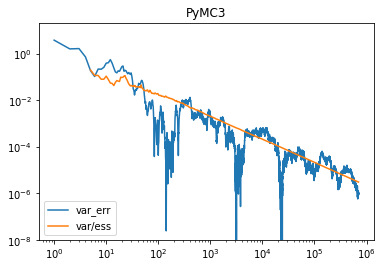

In [44]:
plot_ess_evolution(idata_pymc3.posterior.theta.values, idxs, ess_samples, title="PyMC3")

# PyStan

In [25]:
stan_code = """
data {
    real y;
}

parameters {
    real theta;
}

model {
    theta ~ normal(0, 10);
    y ~ normal(theta, 2);
}
"""

In [27]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_738fff88035c46d13370762c41dcc923 NOW.


In [28]:
fit = stan_model.sampling(data={"y": 0}, chains=4, iter=10**6, warmup=300000)

In [29]:
idata_pystan = az.from_pystan(fit)

In [52]:
idata_pystan.to_netcdf("pystan_post_autocorr.nc")

'pystan_post_autocorr.nc'

In [5]:
idata_pystan = az.from_netcdf("pystan_post_autocorr.nc")

### Chain average

In [39]:
idxs, ess_samples = ess_evolution(idata_pystan.posterior.theta.values)

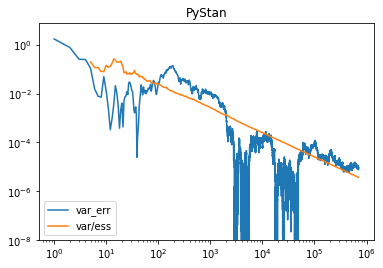

In [42]:
plot_ess_evolution(idata_pystan.posterior.theta.values, idxs, ess_samples, title="PyStan")

# emcee

In [2]:
def lnprob(theta):
    return -13 * theta**2 / 100

In [3]:
nwalkers = 6
ndim = 1
draws = 701000
pos = np.random.normal(size=(nwalkers, ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos, draws, progress=True);

100%|██████████| 701000/701000 [05:55<00:00, 1969.63it/s]


In [4]:
idata_emcee = az.from_emcee(sampler, var_names=["theta"])
idata_emcee.sel(draw=slice(1000, None))

In [14]:
idata_emcee.to_netcdf("emcee_post_autocorr.nc")

'emcee_post_autocorr.nc'

In [2]:
idata_emcee = az.from_netcdf("emcee_post_autocorr.nc")

### Chain average

In [9]:
idxs, ess_samples = ess_evolution(idata_emcee.posterior.theta.values)

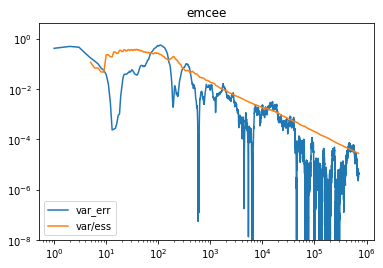

In [10]:
plot_ess_evolution(idata_emcee.posterior.theta.values, idxs, ess_samples, title="emcee")

## Check all samplers got the same posterior

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb25fa3be0>],
      dtype=object)

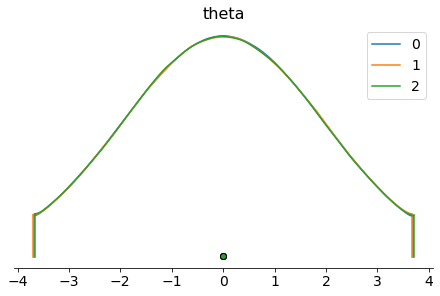

In [15]:
az.plot_density([idata_emcee, idata_pystan, idata_pymc3])